In [37]:
import pandas as pd
import os
import subprocess
from Comparative_Analysis import Utilities as util
from tqdm.auto import tqdm
import re
import pickle
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [34]:
project_dir = 'D:/Project_Data/Project_8'
r_scape_output_loc = project_dir + '/RScape_Run_Thoth_3'
intergenic_regions = util.list_dirs(r_scape_output_loc)
full_run = True
project_dir = 'D:/Project_Data/Project_8'
datasets_dir = project_dir + '/Datasets'
output_dir = project_dir + '/Output'
seq_dir = 'D:/Actinobacteria_Ref_Rep_Lev_Complete'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
reference_species_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
species_list = util.list_files(seq_dir)
reference_species_name = 'Mycobacterium tuberculosis H37Rv'

In [29]:
def ortholog_in_reference(accession_locus, ref_ortholog_dict):
    if accession_locus in ref_ortholog_dict:
        return ref_ortholog_dict[accession_locus].split('@')[1]
    else:
        return 'NO_ORTHOLOG'

In [159]:
with open(output_dir + '/Blast_Output/reciprocal_best_hits.pkl', 'rb') as f:
    rbh_results = pickle.load(f)
ref_ortholog_dict = {}
for i, r in rbh_results.iterrows():
    ref_ortholog_dict[r['target_ref']] = r['query_ref'] 
with open(output_dir + '/gene_info_dict.pkl', 'rb') as f:
    gene_info_dict = pickle.load(f) 
with open(output_dir + '/names_dict.pkl', 'rb') as f:
    names_dict = pickle.load(f) 

In [143]:
refseq_downstream_dict = {}
genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
features = []
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None:
            features.append((a.get("locus_tag")[0], feature.type))
for i,feature in enumerate(features):
    if i+1 < len(features):
        next_feature = features[i+1][1]
        refseq_downstream_dict[feature[0]] = next_feature

In [144]:
mycobrowser_df = pd.read_excel(datasets_dir+'/Mycobrowser_Release_4.xlsx')
features = []
for i, r in mycobrowser_df.iterrows():
    features.append([r['Locus'],r['Start'], r['Product']])
features.sort(key=lambda x: x[1])
downstream_dict = {}
for i, feature in enumerate(features):
    if i + 1 < len(features):
        downstream_dict[feature[0]] = (features[i+1][0])

In [59]:
genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

In [160]:
def generate_hit_dictionary(locus_id):
    genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
    full_sequence = str(genome_record.seq)
    with open(r_scape_output_loc + '/' + locus_id + '/summary.txt', 'r') as f:  
                    hit_dict = {}
                    ref_count = 0
                    tot_count = 0
                    for l in f:
                        if (not ('#' in l)):
                            a = l.split()
                            accession = a[0]
                            species = names_dict[a[0]]
                            seq_from = int(a[7])
                            seq_to = int(a[8])
                            seq_strand = a[9]
                            significant = a[16]
                            start = min(seq_from,seq_to)
                            stop = max(seq_from,seq_to)
                            if (significant == '!'):
                                tot_count+=1
                                feature_list = gene_info_dict[accession]  
                                feature_list.sort(key=lambda x: x[1])
                                max_pct_cover = -1
                                max_feature = []
                                for feature in feature_list:
                                    if feature[1] > stop:      #No point to continue as subsequent features are all after the stop 
                                        continue
                                    if feature[1] < (stop - 1) and feature[2] >= (start - 1):
                                        len_feature = feature[2] - feature[1]
                                        pct_cover = (min(feature[2], stop) - max(feature[1], start)) / (stop - start)
                                        if pct_cover > 0.05 and len_feature < 100000:
                                            if pct_cover > max_pct_cover:
                                                max_feature = feature
                                                max_pct_cover = pct_cover
                                if len(max_feature) > 0:
                                    if max_feature[0][-2:] == 'IG':
                                        region_type = 'IG'
                                        previous_gene = max_feature[3]
                                        next_gene = max_feature[4]
                                        previous_product = max_feature[5][0]
                                        next_product = max_feature[5][1]
                                        output = []
                                        
                                        if previous_gene[1] == 1:
                                            output.append(('Upstream gene', previous_product, a[15], max_pct_cover, seq_from, seq_to)) 
                                        else:
                                             output.append(('Downstream gene', previous_product, a[15], max_pct_cover, seq_from, seq_to))  

                                        if next_gene[1] == 1:
                                            output.append(('Downstream gene', next_product, a[15], max_pct_cover, seq_from, seq_to)) 
                                        else:
                                            output.append(('Upstream gene', next_product, a[15], max_pct_cover, seq_from, seq_to))
                                        
                                        #if previous_gene[1] == 1:
                                        #    output.append(('Upstream gene', ortholog_in_reference(accession + '@' + previous_gene[0], ref_ortholog_dict), a[15], max_pct_cover, seq_from, seq_to)) 
                                        #else:
                                        #     output.append(('Downstream gene', ortholog_in_reference(accession + '@' + previous_gene[0], ref_ortholog_dict), a[15], max_pct_cover, seq_from, seq_to))  
                                        #if next_gene[1] == 1:
                                        #    output.append(('Downstream gene', ortholog_in_reference(accession + '@' + next_gene[0], ref_ortholog_dict), a[15], max_pct_cover, seq_from, seq_to)) 
                                        #else:
                                        #    output.append(('Upstream gene', ortholog_in_reference(accession + '@' + next_gene[0], ref_ortholog_dict), a[15], max_pct_cover, seq_from, seq_to))
                                        if species in hit_dict:
                                            hit_dict[species] = hit_dict[species] + output
                                        else:
                                            hit_dict[species] = output
    return hit_dict

In [161]:
def produce_region_info(id):
    if os.path.isfile(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power'):
        with open(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power', 'r') as f:
            num_covarying = ''
            num_expected = ''  
            for l in f:
                if 'BPAIRS observed' in l:
                    num_covarying = int(l.split('covary ')[1])
                if 'BPAIRS expected' in l:
                    num_expected = (l.split('covary ')[1])
                
            with open(r_scape_output_loc + '/' + id + '/summary.txt', 'r') as f:  
                rfam_overlaps = []
                feature_overlaps = []
                region_type_list = []
                upstream_ortholog_list = []
                downstream_ortholog_list = []
                ref_count = 0
                tot_count = 0
                for l in f:
                    if (not ('#' in l)):
                        a = l.split()
                        species = a[0]
                        seq_from = int(a[7])
                        seq_to = int(a[8])
                        seq_strand = a[9]
                        significant = a[16]
                        start = min(seq_from,seq_to)
                        stop = max(seq_from,seq_to)
                        if (significant == '!'):
                            tot_count+=1
                            feature_list = gene_info_dict[species]  
                            feature_list.sort(key=lambda x: x[1])
                            max_pct_cover = -1
                            max_feature = []
                            for feature in feature_list:
                                if feature[1] > stop:      #No point to continue as subsequent features are all after the stop 
                                    continue
                                if feature[1] < (stop - 1) and feature[2] >= (start - 1):
                                    len_feature = feature[2] - feature[1]
                                    pct_cover = (min(feature[2], stop) - max(feature[1], start)) / (stop - start)
                                    if pct_cover > 0.05 and len_feature < 100000:
                                        if pct_cover > max_pct_cover:
                                            max_feature = feature
                                            max_pct_cover = pct_cover
                                    if len(max_feature) > 0:
                                        if max_feature[0][-2:] == 'IG':
                                            region_type = 'IG'
                                            previous_gene = max_feature[3]
                                            next_gene = max_feature[4]
                                            previous_product = max_feature[5][0]
                                            next_product = max_feature[5][1]
                                            upstream_genes = []
                                            downstream_genes = []
                                            upstream_orthologs = []
                                            downstream_orthologs = []
                                            #if previous_gene[1] == 1:
                                            #    upstream_genes.append(previous_gene[0])
                                            #else:
                                            #    downstream_genes.append(previous_gene[0])
                                            #if next_gene[1] == 1:
                                            #    downstream_genes.append(next_gene[0])
                                            #else:
                                            #    upstream_genes.append(next_gene[0])
                                        #    upstream_orthologs = [ortholog_in_reference(species+ '@' + x, ref_ortholog_dict) for x in upstream_genes]
                                        #    downstream_orthologs = [ortholog_in_reference(species + '@' + x, ref_ortholog_dict) for x in downstream_genes]
                                            if previous_gene[1] == 1:
                                                upstream_genes.append(previous_product)
                                            else:
                                                downstream_genes.append(previous_product)
                                            if next_gene[1] == 1:
                                                downstream_genes.append(next_product)
                                            else:
                                                upstream_genes.append(next_product)
                                            upstream_orthologs = upstream_genes
                                            downstream_orthologs = downstream_genes
                                        
                                        
                                        else:
                                            region_type = 'G'
                                        
                                        region_type_list.append(region_type)
                                        if region_type == 'IG':
                                            upstream_ortholog_list.append(upstream_orthologs)
                                            downstream_ortholog_list.append(downstream_orthologs)
                                        
                            # RFAM overlaps for reference hits
                            if species == 'NC_000962.3':
                                ref_count+=1
                                for i, r in rfam_df.iterrows():
                                    rfam_start = min(int(r['seq from']), int(r['seq to']))
                                    rfam_stop = max(int(r['seq from']), int(r['seq to']))
                                    pct_cover = (min(rfam_stop, stop) - max(rfam_start, start)) / (rfam_stop - rfam_start)
                                    if pct_cover > 0.1:
                                        rfam_overlaps.append((r.accession, r['description of target'], pct_cover))
            
            # Near covarying pairs - suggests not structural, possibly CDS
            with open(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.R2R.sto', 'r') as f: 
                r2r_near_pairs = 0
                for l in f:
                    if '#=GC SS_cons ' in l:
                        for i in range(len(l)-2):
                            if l[i:(i+2)] == '<>':
                                r2r_near_pairs +=1
        
        if id in refseq_downstream_dict:
            refseq_downstream = refseq_downstream_dict[id]
        else:
            refseq_downstream = ''
        if len(region_type_list) > 0:
            intergenic_pct = region_type_list.count('IG') / len(region_type_list)
        else:
            intergenic_pct = 0
        return ([id, num_covarying, num_expected, ref_count, tot_count, intergenic_pct, r2r_near_pairs])
    else:
        return([id, 0 , 0, 0, 0, 0, 0])


In [3]:
def overlap_metric(positions_1, positions_2):
    if len(positions_1) < len(positions_2):
        a = positions_1
        b = positions_2
    else:
        a = positions_2
        b = positions_1
    num_comparisons = len(a)
    num_overlaps = 0
    for coord_1 in a:
        for coord_2 in b:
            x, y = np.argsort(coord_1+coord_2)[:2] > 1
            if x != y:
                num_overlaps += 1
                break
    return 1 - num_overlaps / num_comparisons

In [4]:
ids =  util.list_dirs(r_scape_output_loc)
len(ids)

1821

In [5]:
overlap_metric([[0,100],[2000,3000]], [[40,50],[250,450],[0,1]])

0.5

In [152]:
positions_list = []
for id in ids:
    locus = id
    if os.path.isfile(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power'):
        with open(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power', 'r') as f:
            positions = []
            for l in f:
                if 'BPAIRS observed' in l:
                    if int(l.split('covary ')[1]) > 4:
                        positions = []
                        with open(r_scape_output_loc + '/' + id + '/summary.txt', 'r') as g:
                             for l in g:
                                if not(l[0] == '#'): 
                                    a = l.split()
                                    if a[16] == '!':
                                        if a[0] == 'NC_000962.3':
                                            positions.append((min(int(a[7]),int(a[8])), max(int(a[7]),int(a[8]))))
        if len(positions)>0:
            positions = set(positions)
            positions_list.append((locus, positions))
    

In [171]:
ref_positions_dict = {}
for pos in positions_list:
    ref_positions_dict[pos[0]] = list(pos[1])

In [153]:
distance_matrix = np.zeros((len(positions_list), len(positions_list)))
for i, (locus, positions) in enumerate(positions_list):
    for j, (locus_2, positions_2) in enumerate(positions_list):
        distance_matrix[i,j] = overlap_metric(positions, positions_2)

In [154]:
clustering = AgglomerativeClustering(affinity="precomputed",  linkage = 'average', distance_threshold = 0.2, n_clusters = None).fit_predict(distance_matrix)
clustering

array([ 31, 113, 130,  75,  28, 112, 111, 110, 109, 141, 108,  58,   2,
         2, 107,   2,  28, 106, 105, 121, 104, 103,  14,  30, 102,  15,
        15,  68,  28,  15,  15,  59,  33,  11, 101,  11,  99,  98,   2,
         2,   2, 138,  15,  97,  32,  15, 122,  96,  95,  94,  93,  15,
       123,  92,  34,  91,  90,   2,   6,  89,  13,  88,  87,  15,  86,
         3,   3,   7,  85,  16,  14,  84,  62,  15,   4,  83,  82,  81,
        15,  15,  14,  80, 126,  79,  15,  28,  78,  77,  76,  37,   2,
         3,   2,  15,  15,  15,  65,  17,  15,  14,   1,   0, 140,  10,
         6,  15,  74,  15,  73,   5,  72, 143,  16,  14,  16,  59, 142,
        34,  15, 139,  15,   3,   2,   2, 137, 135,  71, 133, 131, 129,
         9, 116, 127, 125,  58,   2,  60, 119, 117, 115, 114,  55,  54,
         9,  53,  15,  30,  52,   5,  50,  15, 100,  48,  15,   2,  15,
        32,  15,  15,  15,   1,  30,  34,   6,   1,  15,   2,  47,   8,
         3,  46,  15,   0,  45,  44,   8,  15,  15,  62,  42,  4

<AxesSubplot:ylabel='Count'>

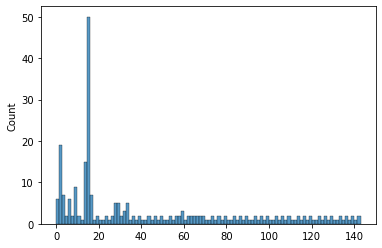

In [155]:
sns.histplot(data = clustering, bins = 100)

In [156]:
cluster_hits = []
num_clusters = max(clustering) + 1
for i in range(num_clusters):
    num_members = 0
    members = []
    co_ords = []
    largest_hits = 0
    largest_hit_member = ''
    largest_hit_positions = []
    for j, clust in enumerate(clustering):
        
        if clust == i:
            num_members +=1
            members.append(positions_list[j][0])
            if len(positions_list[j][1]) > largest_hits:
                largest_hits = len(positions_list[j][1])
                co_ords = positions_list[j][1]
                largest_hit_member = positions_list[j][0]
    cluster_hits.append([i, largest_hits/num_members, num_members, members, co_ords, largest_hit_member, largest_hits])

In [203]:
rfam_df = pd.read_excel(datasets_dir+'/RFAM_Hits_H37Rv_sorted.xlsx')
temp_df_list = []
for cluster in cluster_hits:
    highest_covarying_bp = 0
    highest_covarying_member = ''
    highest_a = []
    for member in cluster[3]:
        a = produce_region_info(member)
        if a[1]>highest_covarying_bp:
            highest_covarying_bp = a[1]
            highest_covarying_member = member
            highest_a = a
    #representative_member = cluster[5]
    representative_member = highest_covarying_member
    if a[5] < 0.5:
        continue
    
    hit_dict = generate_hit_dictionary(representative_member)
    RFAM_hits = [] 
    for coord in cluster[4]:
        start_coord = min(coord[0], coord[1])
        end_coord = max(coord[0], coord[1])
        rfam_match = 0
        for i, r in rfam_df.iterrows():
            start = min(r['seq from'], r['seq to'])
            stop = max(r['seq from'], r['seq to'])
            match = 0
            for feature in features:
                if start_coord < stop and end_coord > start:
                        RFAM_hits.append(r['target name'])
                        rfam_match = 1
                        break
    if rfam_match == 0:
       
        print(cluster[0], cluster[2], cluster[3], representative_member, ref_positions_dict[representative_member])
        region_info = produce_region_info(representative_member)
        print(region_info)
        print ('*******************')
        upstream_dict = {}
        downstream_dict = {}
        for k, v in hit_dict.items():
            for hit in v:
                if hit[0] == 'Upstream gene':
                    if hit[1] in upstream_dict:
                        upstream_dict[hit[1]] +=1
                    else:
                        upstream_dict[hit[1]] = 1
                else:
                    if hit[1] in downstream_dict:
                        downstream_dict[hit[1]] +=1
                    else:
                        downstream_dict[hit[1]] = 1
        significant_downstream_products = []
        significant_upstream_products = []
        for k, v in dict(sorted(downstream_dict.items(), key = lambda x: x[1], reverse=True)).items():
            if k == 'hypothetical protein': 
                pass
            elif v>2:
                significant_downstream_products.append((k, v))

        for k, v in dict(sorted(upstream_dict.items(), key = lambda x: x[1], reverse=True)).items():
            if k == 'hypothetical protein': 
                pass
            elif v>2:
                significant_upstream_products.append((k, v))
        temp_df_list.append([cluster[0], cluster[2], cluster[3], representative_member, ref_positions_dict[representative_member], 
                            region_info[1], region_info[2], region_info[3],region_info[4], region_info[5], region_info[6],
                            sorted(significant_downstream_products, key= lambda item: item[1], reverse = True), sorted(significant_upstream_products, key= lambda item: item[1], reverse = True)])
cluster_info_df = pd.DataFrame(temp_df_list, columns = ['Cluster_ID', 'Number of Members' , 'Members', 'Representative', 'Hit Positions in Reference', 'BP_Covarying', 'Predicted_BP_Covarying', 'Num_Reference_Hits', 'Total_Hits', 'Intergenic_Pct', 'Near_BPs_covarying', 
                                                       'Significant_Downstream_Products', 'Significant_Upstream_Produts'])

0 2 ['Rv1275', 'Rv2486'] Rv2486 [(958452, 958520), (1133263, 1133330), (736227, 736295), (1425313, 1425381), (1064047, 1064115), (96889, 96957), (736230, 736298), (2795189, 2795255)]
['Rv2486', 13, '20.6 +/- 1.4\n', 8, 647, 0.9349363507779349, 0]
*******************
1 4 ['Rv1260', 'Rv2297', 'Rv2394', 'Rv2695'] Rv2695 [(4159799, 4159872), (3012663, 3012737), (1017147, 1017221), (1197124, 1197198), (1409395, 1409469), (2991114, 2991188), (1198074, 1198148), (277769, 277843)]
['Rv2695', 26, '29.0 +/- 1.6\n', 8, 622, 0.8088888888888889, 0]
*******************
2 19 ['MTB000141', 'MTB000150', 'Rv0006', 'Rv0480c', 'Rv0487', 'Rv0504c', 'Rv0823c', 'Rv1155', 'Rv1173', 'Rv1668c', 'Rv1682', 'Rv1866', 'Rv2196', 'Rv2405', 'Rv2945c', 'Rv3217c', 'Rv3401', 'Rv3505', 'Rv3680'] Rv1668c [(2115620, 2115761), (3690943, 3691077), (3351086, 3351216), (1895459, 1895590), (577286, 577390), (1443358, 1443493), (3594349, 3594452), (2401808, 2401937), (577391, 577519), (1955569, 1955684), (2703892, 2704026), (5953

In [204]:
pd.set_option('display.max_colwidth', 200)
for i, r in cluster_info_df.iterrows():
    a = r.transpose()
    print(a)
    print("")
    print("")

Cluster_ID                                                                                                                                                                                                                               0
Number of Members                                                                                                                                                                                                                        2
Members                                                                                                                                                                                                                   [Rv1275, Rv2486]
Representative                                                                                                                                                                                                                      Rv2486
Hit Positions in Reference                                  

<AxesSubplot:ylabel='Count'>

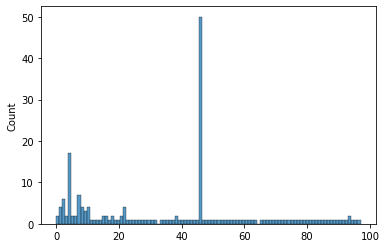

In [13]:
sns.histplot(data = clustering, bins = 100)

In [92]:
mycobrowser_df = pd.read_excel(datasets_dir+'/Mycobrowser_Release_4.xlsx')
features = []
for i, r in mycobrowser_df.iterrows():
    features.append([r['Locus'],r['Start'], r['Stop'], r['Product']])

In [93]:
rfam_df = pd.read_excel(datasets_dir+'/RFAM_Hits_H37Rv_sorted.xlsx')

In [100]:
rfam_df = pd.read_excel(datasets_dir+'/RFAM_Hits_H37Rv_sorted.xlsx')
for i, r in rfam_df.iterrows():
    start = min(r['seq from'], r['seq to'])
    stop = max(r['seq from'], r['seq to'])
    match = 0
    for feature in features:
        if feature[1] < stop and feature[2] > start:
                match = 1
    if match == 0:
        print(r['#idx'], r['target name'], r[')
    

82 Glycine
25 ydaO-yuaA
17 Cobalamin
13 M-box
21 SAM-IV
22 group-II-D1D4-4
